In [25]:
from sklearn.utils import murmurhash3_32 as mmh3
import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms.simple_paths import all_simple_paths as nx_get_paths
from collections import defaultdict 
import random
import time
import math
import sys
from functools import partial
from multiprocessing import Pool

In [78]:
# Enable/disable MULTIPROCESSING
MP_FLAG = False
NUM_PROCS = 3
SEED = 24
random.seed(SEED)

In [27]:
# Helper functions
def subgraphs_n(graph):
    """
    Returns dictionary of keys corresponding to number of nodes and values 
    corresponding to list of connected subgraphs in graph with that many nodes
    
    graph is a networkx graph
    """
    subgraphs = list(nx.weakly_connected_component_subgraphs(graph))
    subgraphs_n = defaultdict(list)
    for subgraph in subgraphs:
        subgraphs_n[nx.number_of_nodes(subgraph)].append(subgraph)
    return subgraphs_n

def attributes(x):
    """
    Returns "number of source nodes, number of outgoing edges per node..." 
    all concatenated which is equivalent to d(x, 0) for connectivity matrix x
    
    x is a pandas dataframe of connectivity matrix
    """
    n = len(x)
    
    # Initialize with counter of source nodes
    result = [0]
    
    # Increment counter for number of source nodes
    for j in range(n):
        for i in range(n):
            if x.iloc[i,j] != 0:
                break
            elif i == n - 1:
                result[0] += 1
    result[0] = str(result[0])
    # Append sorted list of number of outgoing edges per node
    result.extend(sorted([str(int(sum(x.iloc[i]))) for i in range(n)]))
    result_string = "".join(result)
    return result_string

def subgraph_hash(subgraphs_n, n, r):
    """
    subgraphs_n is the dictionary of number of nodes and lists of subgraphs with
    that many nodes
    n is size of subgraph we are hashing for
    r is measurement of similarity (in paper). As r goes down, we are being more accurate.
    """
    # Start measuring time taken for this hashing method
    start_time = time.time()
    random.seed(24)
    # Sample from n + 1 - r positions of the hash
    positions = sorted(random.sample(range(n + 1), n + 1 - r))
#     print(positions)
    # Initialize hash table
    table = defaultdict(list)
    # For each subgraph of size n
    for subgraph in subgraphs_n[n]:
        # Get the hash "number of source nodes, number of outgoing edges per node..." 
        characteristics = attributes(nx.to_pandas_adjacency(subgraph))
        hash_key = []
        # Sample n + 1 - r positions of the hash
        for p in positions:
            hash_key.append(characteristics[p])
        hash_key_string = "".join(hash_key)
        # Add subgraph to that key in the hash table
        table[hash_key_string].append(subgraph)
    # Stop timing
    end_time = time.time()
#     print(str(n) + ": " + str(end_time - start_time))
#     print(sys.getsizeof(table))
#     return {"subgraph size": n, "hashtable": table, "time":end_time - start_time}

# TODO: 2) Memory curves - make a memory curve for super big graphs that 
# have way more subgraphs per size than just 4514 because this will hopefully 
# show a progression in the memory. Right now, because of how dictionaries are 
# implemented in Python, the change doesn’t look legit. 
# I did that and realized that the way of measuring memory was maybe incorrect due to
# Python's implementation of dictionaries.
    return {"subgraph size": n, "number subgraphs": len(subgraphs_n[n]),"time":end_time - start_time,"memory":sum([sys.getsizeof(value) for value in table.values()])}

def total_hash(graph, n, r):
    """
    graph is the total graph
    n is size of subgraph we are hashing for
    r is measurement of similarity (in paper). As r goes down, we are being more accurate.
    """
    # Get all the subgraphs categorized into different sizes
    sgn = subgraphs_n(graph)
    # Print how many graphs there are of size 3, 4, 5, 6
    print(len(sgn[3]), len(sgn[4]), len(sgn[5]), len(sgn[6]))
    # Hash subgraphs of size n with similarity level r
    return subgraph_hash(sgn, n, r)
#     print(table)    

In [28]:
# Uniform means that I want to make the number of subgraphs of 
# size 3, 4, 5, 6 the same so that it is not the number of subgraphs
# themselves that affect memory or time taken

# This is necessary for our graphs to be valid!!!
def subgraphs_n_uniform(graph):
    subgraphs = list(nx.weakly_connected_component_subgraphs(graph))
    subgraphs_n = defaultdict(list)
    for subgraph in subgraphs:
        subgraphs_n[nx.number_of_nodes(subgraph)].append(subgraph)
    # Get the minimum count of subgraphs of size 3, 4, 5, 6
    count = min(len(subgraphs_n[3]), len(subgraphs_n[4]), len(subgraphs_n[5]), len(subgraphs_n[6]))
    # Sample that number of subgraphs for each size so now they all have the same number of subgraphs
    for i in range(3, 7):
        subgraphs_n[i] = random.sample(subgraphs_n[i], count)
    return subgraphs_n
# total_hash_uniform is just using subgraphs_n_uniform instead now
def total_hash_uniform(graph, n, r):
    sgn = subgraphs_n_uniform(graph)
#     print(len(sgn[3]), len(sgn[4]), len(sgn[5]), len(sgn[6]))
    return subgraph_hash(sgn, n, r)

In [29]:
# # TODO: 1) Time curves - create time curves for more number of subgraphs (not just 395, 824, 4514)
# 395
graph_1 = nx.fast_gnp_random_graph(100000, 0.000003, seed=SEED, directed=True)
# 614
graph_2 = nx.fast_gnp_random_graph(600000, 0.00000027, seed=SEED, directed=True)
# 824
graph_3 = nx.fast_gnp_random_graph(500000, 0.0000004, seed=SEED, directed=True)
# 1390
graph_4 = nx.fast_gnp_random_graph(700000, 0.00000030, seed=SEED, directed=True)
# 2229
graph_5 = nx.fast_gnp_random_graph(800000, 0.00000031, seed=SEED, directed=True)
# 3442
graph_6 = nx.fast_gnp_random_graph(900000, 0.00000033, seed=SEED, directed=True)
# 4514
graph_7 = nx.fast_gnp_random_graph(1000000, 0.00000035, seed=SEED, directed=True)

# TODO: 0) Create big graphs with a lottt of subgraphs!!! 
# # 14441
# graph_big = nx.fast_gnp_random_graph(3000000, 0.000000129, seed=SEED, directed=True)

graphs = [(graph_1, 1), (graph_2, 2), (graph_3, 3), (graph_4, 4), (graph_5, 5), (graph_6, 6), (graph_7, 7)]
# graphs = [(graph_big, 1)]
results = {}
r_val = 3

def pfunc(x, graph, r):
    return total_hash_uniform(graph, x, r)

start = time.time()
if MP_FLAG:
    with Pool(NUM_PROCS) as p:
        for g, g_idx in graphs:
            part_func = partial(pfunc, graph = g)
            res = p.map(part_func, range(3,7))
            results[g_idx] = res
            for r in res:
                print(r["subgraph size"], r["time"])
else:
    print("normal processing")
    # Generate a random graph of size 100000, probability of edge 0.000003.
    for g, g_idx in graphs:
        results[g_idx] = []
        for n in range(3, 7):
            res = pfunc(n, g, int(math.ceil(n*1.0/2)))
#             res = pfunc(n, g, r_val)
            results[g_idx].append(res)
            print(res["subgraph size"], res["time"])

    # First line printed is number of subgraphs size 3, 4, 5, 6. Should be equal for total_hash_uniform.
    # Next line is "number of nodes: time taken to hash subgraphs of that many nodes"
    # Next line is how much memory is used in the hash table (this doesn't change a lot
    # so we should use larger graphs to show the change
end = time.time()
end-start

normal processing
3 0.5172808170318604
4 0.6151039600372314
5 0.7211399078369141
6 0.8681931495666504
3 0.8145649433135986
4 0.9729588031768799
5 1.1357817649841309
6 1.310851812362671
3 1.0749571323394775
4 1.2863729000091553
5 1.4960529804229736
6 1.745028018951416
3 1.830826997756958
4 2.1580748558044434
5 2.881448984146118
6 2.894836902618408
3 2.902796983718872
4 3.4611687660217285
5 4.094232082366943
6 4.9856297969818115
3 5.1424782276153564
4 5.409775018692017
5 6.191575050354004
6 7.1607630252838135
3 5.872264862060547
4 7.47238826751709
5 8.473233938217163
6 9.602304935455322


998.2212810516357

In [30]:
for res in results:
    print(results[res])

[{'subgraph size': 3, 'number subgraphs': 395, 'time': 0.5172808170318604, 'memory': 3448}, {'subgraph size': 4, 'number subgraphs': 395, 'time': 0.6151039600372314, 'memory': 3800}, {'subgraph size': 5, 'number subgraphs': 395, 'time': 0.7211399078369141, 'memory': 3784}, {'subgraph size': 6, 'number subgraphs': 395, 'time': 0.8681931495666504, 'memory': 3808}]
[{'subgraph size': 3, 'number subgraphs': 614, 'time': 0.8145649433135986, 'memory': 5720}, {'subgraph size': 4, 'number subgraphs': 614, 'time': 0.9729588031768799, 'memory': 5528}, {'subgraph size': 5, 'number subgraphs': 614, 'time': 1.1357817649841309, 'memory': 5696}, {'subgraph size': 6, 'number subgraphs': 614, 'time': 1.310851812362671, 'memory': 5584}]
[{'subgraph size': 3, 'number subgraphs': 824, 'time': 1.0749571323394775, 'memory': 7424}, {'subgraph size': 4, 'number subgraphs': 824, 'time': 1.2863729000091553, 'memory': 7216}, {'subgraph size': 5, 'number subgraphs': 824, 'time': 1.4960529804229736, 'memory': 7272

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
plt.style.use('seaborn')

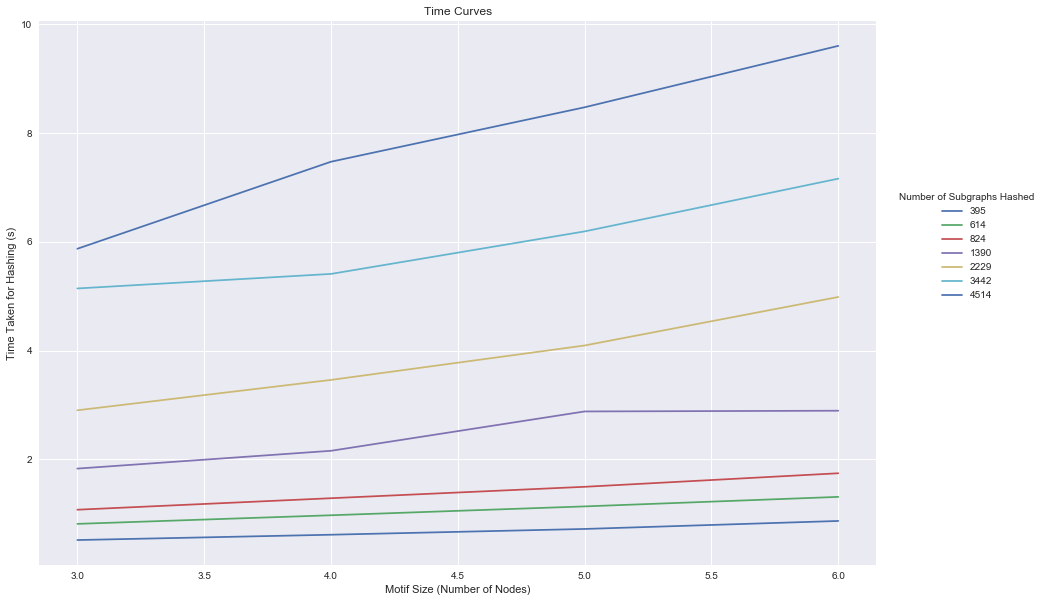

In [68]:
import matplotlib.pyplot as plt
# def time_curve(times, sizes):            
#     colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k']
#     for i in range(len(sizes)):
#         plt.plot([3, 4, 5, 6], times[i], colors[i], marker = "x")
#     plt.title("Time Curves")
#     plt.xlabel("Motif Size")
#     plt.ylabel("Time Taken for Hashing")
#     plt.legend(sizes, loc="upper left", title="Number of Subgraphs Hashed")
#     plt.show()
# I know this looks hard code-y but these were the numbers I got in my first run.
plt.figure(figsize=(15,10))
for res in results:
    times = [r['time'] for r in results[res]]
    sizes = [r['subgraph size'] for r in results[res]]
    num_subgraphs = results[res][0]['number subgraphs']
    plt.plot(sizes, times, marker = "x", label = num_subgraphs)
#     plt.title("Time Curves (r = "+str(r_val)+")")
    plt.title("Time Curves")
    plt.xlabel("Motif Size (Number of Nodes)")
    plt.ylabel("Time Taken for Hashing (s)")
    #     plt.show()
plt.legend(bbox_to_anchor=(1.2,0.7), loc="upper right", title="Number of Subgraphs Hashed")
plt.show()

# time_curve([[0.5374, 0.6214, 0.6779, 0.8459]], [395])
# time_curve([[1.2100, 1.3620, 1.5745, 1.8273]], [824])
# time_curve([[5.4358, 7.3154, 8.1447, 8.9011]], [4514])
# time_curve([[0.5374, 0.6214, 0.6779, 0.8459], [1.2100, 1.3620, 1.5745, 1.8273], [5.4358, 7.3154, 8.1447, 8.9011]], [395, 824, 4514])

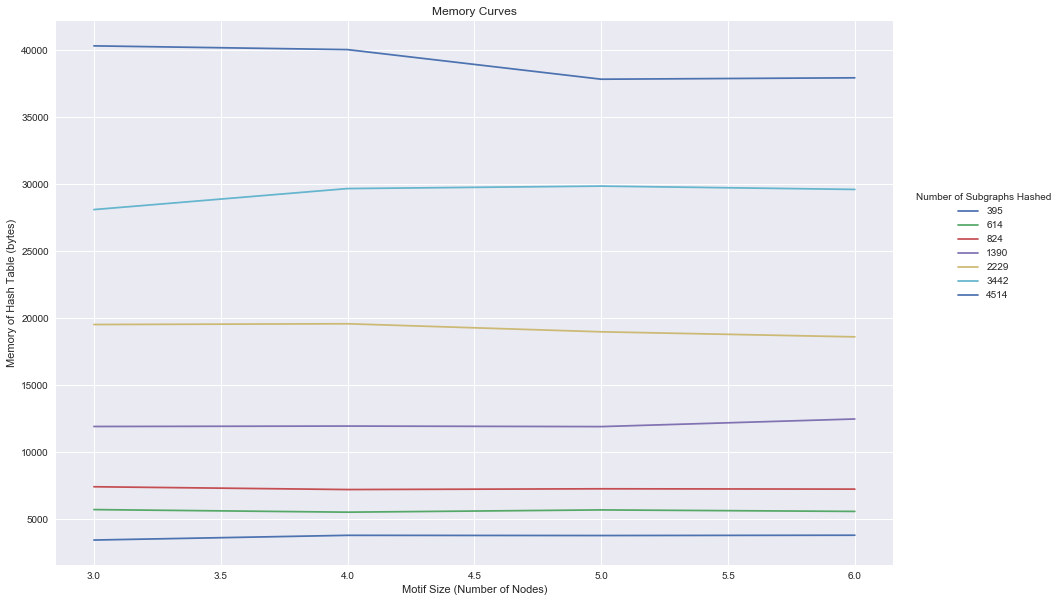

In [71]:
import matplotlib.pyplot as plt
# # Memory is defined as size of hash table + size of lists within hash table (due to pointers?)
# def memory_curve(mems, sizes):            
#     colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k']
#     plt.figure()
#     for i in range(len(sizes)):
#         plt.plot([3, 4, 5, 6], mems[i], colors[i], marker = "x")
#     plt.title("Memory Curves")
#     plt.xlabel("Motif Size")
#     plt.ylabel("Memory of Hash Table")
#     plt.legend(sizes, loc="upper left", title="Number of Subgraphs Hashed")
#     plt.show()

plt.figure(figsize=(15,10))
for res in results:
    mems = [r['memory'] for r in results[res]]
    sizes = [r['subgraph size'] for r in results[res]]
    num_subgraphs = results[res][0]['number subgraphs']
    plt.plot(sizes, mems, marker = "x", label = num_subgraphs)
#     plt.title("Time Curves (r = "+str(r_val)+")")
    plt.title("Memory Curves")
    plt.xlabel("Motif Size (Number of Nodes)")
    plt.ylabel("Memory of Hash Table (bytes)")
    #     plt.show()
plt.legend(bbox_to_anchor=(1.2,0.7), loc="upper right", title="Number of Subgraphs Hashed")
plt.show()

# memory_curve([[248, 248, 248, 248]], [395])
# memory_curve([[248, 248, 248, 248]], [824])
# memory_curve([[248, 248, 248, 376]], [4514])
# memory_curve([[248, 248, 248, 248], [248, 248, 248, 248], [248, 248, 248, 376]], [395, 824, 4514])

In [72]:
# Helper functions
def subgraph_hash_improved(subgraphs_n, n):
    """
    subgraphs_n is the dictionary of number of nodes and lists of subgraphs with
    that many nodes
    n is size of subgraph we are hashing for
    """
    # Start measuring time taken for this hashing method
    start_time = time.time()
    random.seed(24)
    # Initialize hash table
    table = defaultdict(list)
    # For each subgraph of size n
    for subgraph in subgraphs_n[n]:
        # Get the hash "number of edges"
        hash_key_string = str(subgraph.number_of_edges())
        # Add subgraph to that key in the hash table
        table[hash_key_string].append(subgraph)
    # Stop timing
    end_time = time.time()

    return {"subgraph size": n, "number subgraphs": len(subgraphs_n[n]),"time":end_time - start_time,"memory":sum([sys.getsizeof(value) for value in table.values()])}

# Uses subgraph_hash_improved instead (don't need to change this)
def total_hash_uniform_improved(graph, n):
    sgn = subgraphs_n_uniform(graph)
#     print(len(sgn[3]), len(sgn[4]), len(sgn[5]), len(sgn[6]))
    return subgraph_hash_improved(sgn, n)

In [73]:
# TODO: 4) Get the run times of hashing with this new distance metric to compare 
# it with the hashing in Legault’s paper. To get a better run time, the distance 
# metric should require less processing so honestly we could just make a really 
# shitty distance metric to get a really good run time.
# # TODO: 1) Time curves - create time curves for more number of subgraphs (not just 395, 824, 4514)
# 395
graph_1 = nx.fast_gnp_random_graph(100000, 0.000003, seed=SEED, directed=True)
# 614
graph_2 = nx.fast_gnp_random_graph(600000, 0.00000027, seed=SEED, directed=True)
# 824
graph_3 = nx.fast_gnp_random_graph(500000, 0.0000004, seed=SEED, directed=True)
# 1390
graph_4 = nx.fast_gnp_random_graph(700000, 0.00000030, seed=SEED, directed=True)
# 2229
graph_5 = nx.fast_gnp_random_graph(800000, 0.00000031, seed=SEED, directed=True)
# 3442
graph_6 = nx.fast_gnp_random_graph(900000, 0.00000033, seed=SEED, directed=True)
# 4514
graph_7 = nx.fast_gnp_random_graph(1000000, 0.00000035, seed=SEED, directed=True)

# TODO: 0) Create big graphs with a lottt of subgraphs!!! 
# 14441
# graph_big = nx.fast_gnp_random_graph(3000000, 0.000000129, seed=SEED, directed=True)

graphs = [(graph_1, 1), (graph_2, 2), (graph_3, 3), (graph_4, 4), (graph_5, 5), (graph_6, 6), (graph_7, 7)]
# graphs = [(graph_big, 1)]
results = {}
r_val = 3

def pfunc_improved(x, graph):
    return total_hash_uniform_improved(graph, x)

start = time.time()
if MP_FLAG:
    with Pool(NUM_PROCS) as p:
        for g, g_idx in graphs:
            part_func = partial(pfunc_improved, graph = g)
            res = p.map(part_func, range(3,7))
            results[g_idx] = res
            for r in res:
                print(r["subgraph size"], r["time"])
else:
    print("normal processing")
    # Generate a random graph of size 100000, probability of edge 0.000003.
    for g, g_idx in graphs:
        results[g_idx] = []
        for n in range(3, 7):
            res = pfunc_improved(n, g)
#             res = pfunc(n, g, r_val)
            results[g_idx].append(res)
            print(res["subgraph size"], res["time"])

    # First line printed is number of subgraphs size 3, 4, 5, 6. Should be equal for total_hash_uniform.
    # Next line is "number of nodes: time taken to hash subgraphs of that many nodes"
    # Next line is how much memory is used in the hash table (this doesn't change a lot
    # so we should use larger graphs to show the change
end = time.time()
end-start

normal processing
3 0.0030062198638916016
4 0.0031728744506835938
5 0.0034148693084716797
6 0.003737926483154297
3 0.004628896713256836
4 0.004790067672729492
5 0.005759000778198242
6 0.005625009536743164
3 0.00604701042175293
4 0.00673985481262207
5 0.007208824157714844
6 0.008007049560546875
3 0.011091947555541992
4 0.012817859649658203
5 0.012380123138427734
6 0.014100074768066406
3 0.016518115997314453
4 0.01786208152770996
5 0.019609928131103516
6 0.021957874298095703
3 0.028291940689086914
4 0.027746200561523438
5 0.030034780502319336
6 0.03261113166809082
3 0.03512907028198242
4 0.040817975997924805
5 0.04905390739440918
6 0.04458189010620117


938.6817278862

In [74]:
for res in results:
    print(results[res])

[{'subgraph size': 3, 'number subgraphs': 395, 'time': 0.0030062198638916016, 'memory': 3304}, {'subgraph size': 4, 'number subgraphs': 395, 'time': 0.0031728744506835938, 'memory': 3304}, {'subgraph size': 5, 'number subgraphs': 395, 'time': 0.0034148693084716797, 'memory': 3304}, {'subgraph size': 6, 'number subgraphs': 395, 'time': 0.003737926483154297, 'memory': 3304}]
[{'subgraph size': 3, 'number subgraphs': 614, 'time': 0.004628896713256836, 'memory': 5496}, {'subgraph size': 4, 'number subgraphs': 614, 'time': 0.004790067672729492, 'memory': 5496}, {'subgraph size': 5, 'number subgraphs': 614, 'time': 0.005759000778198242, 'memory': 5496}, {'subgraph size': 6, 'number subgraphs': 614, 'time': 0.005625009536743164, 'memory': 5496}]
[{'subgraph size': 3, 'number subgraphs': 824, 'time': 0.00604701042175293, 'memory': 7056}, {'subgraph size': 4, 'number subgraphs': 824, 'time': 0.00673985481262207, 'memory': 7056}, {'subgraph size': 5, 'number subgraphs': 824, 'time': 0.0072088241

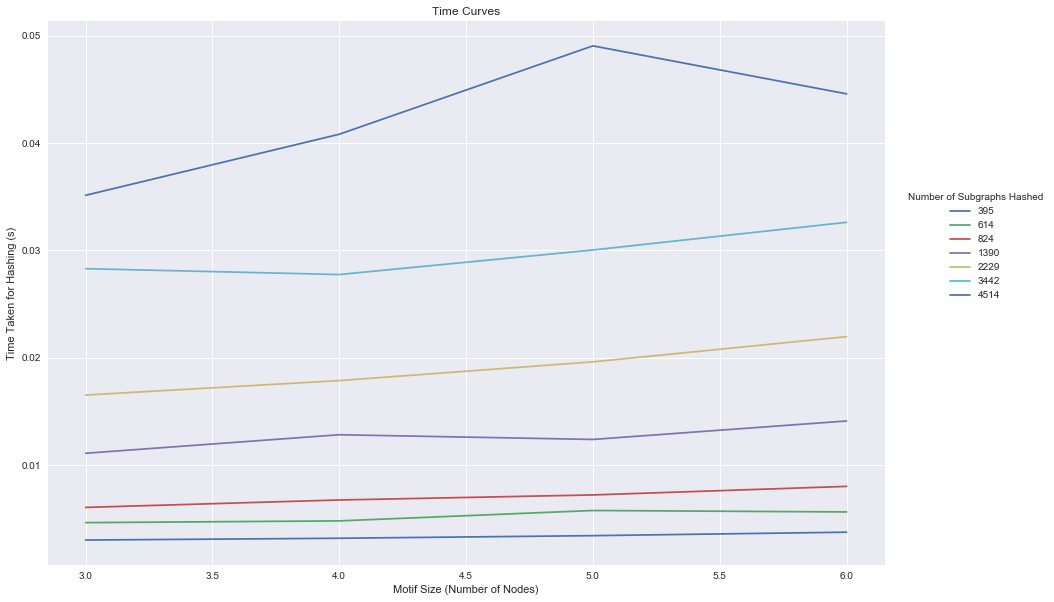

In [76]:
plt.figure(figsize=(15,10))
for res in results:
    times = [r['time'] for r in results[res]]
    sizes = [r['subgraph size'] for r in results[res]]
    num_subgraphs = results[res][0]['number subgraphs']
    plt.plot(sizes, times, marker = "x", label = num_subgraphs)
#     plt.title("Time Curves (r = "+str(r_val)+")")
    plt.title("Time Curves")
    plt.xlabel("Motif Size (Number of Nodes)")
    plt.ylabel("Time Taken for Hashing (s)")
    #     plt.show()
plt.legend(bbox_to_anchor=(1.2,0.7), loc="upper right", title="Number of Subgraphs Hashed")
plt.show()

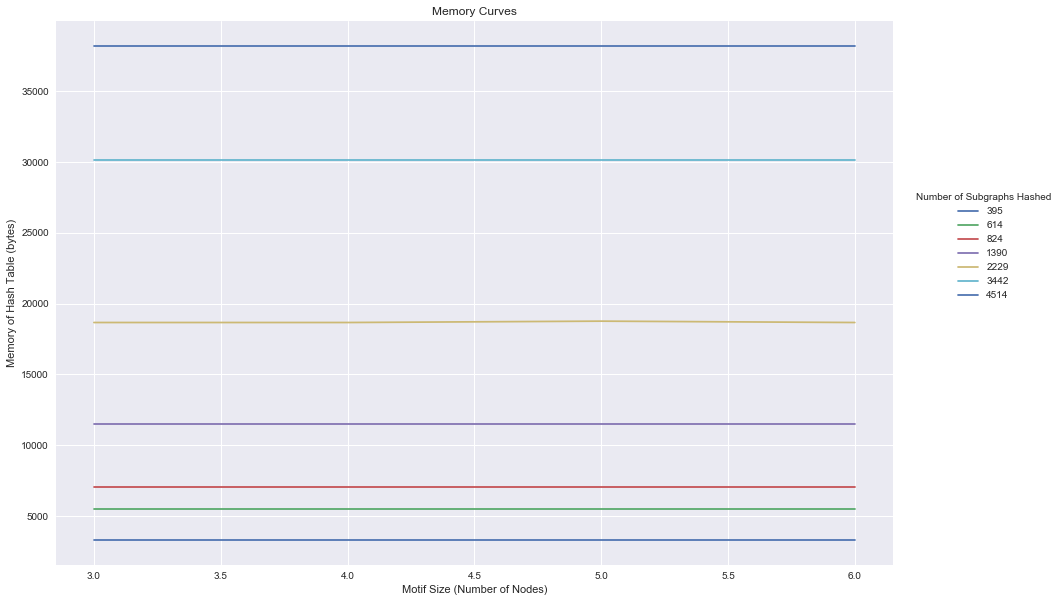

In [77]:
plt.figure(figsize=(15,10))
for res in results:
    mems = [r['memory'] for r in results[res]]
    sizes = [r['subgraph size'] for r in results[res]]
    num_subgraphs = results[res][0]['number subgraphs']
    plt.plot(sizes, mems, marker = "x", label = num_subgraphs)
#     plt.title("Time Curves (r = "+str(r_val)+")")
    plt.title("Memory Curves")
    plt.xlabel("Motif Size (Number of Nodes)")
    plt.ylabel("Memory of Hash Table (bytes)")
    #     plt.show()
plt.legend(bbox_to_anchor=(1.2,0.7), loc="upper right", title="Number of Subgraphs Hashed")
plt.show()

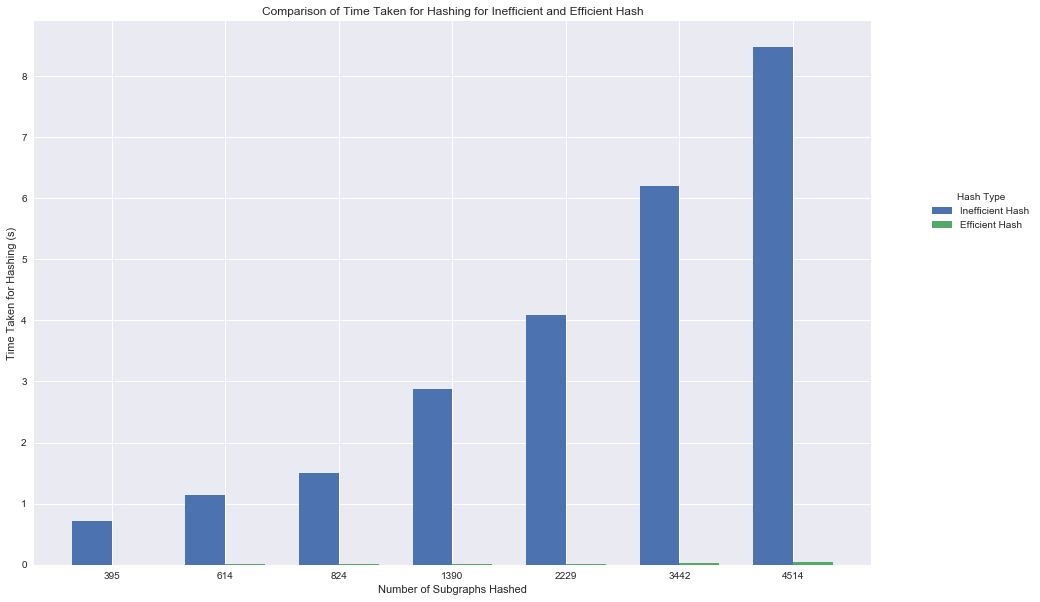

In [75]:
N = 7
# Numbers for motif size 5 (4dp)
old_hash = (0.7211, 1.1358, 1.4961, 2.8814, 4.0942, 6.1916, 8.4732)
new_hash = (0.0034, 0.0058, 0.0072, 0.0124, 0.0196, 0.0300, 0.0491)

ind = np.arange(N) 
width = 0.35
plt.figure(figsize=(15,10))
plt.bar(ind, old_hash, width, label='Inefficient Hash')
plt.bar(ind + width, new_hash, width, label='Efficient Hash')

plt.xlabel('Number of Subgraphs Hashed')
plt.ylabel('Time Taken for Hashing (s)')
plt.title('Comparison of Time Taken for Hashing for Inefficient and Efficient Hash')

plt.xticks(ind + width / 2, ('395', '614', '824', '1390', '2229', '3442', '4514'))
plt.legend(bbox_to_anchor=(1.2,0.7), loc="upper right", title="Hash Type")
plt.show()

In [112]:
# TODO: 5) Show the tradeoff between run time and accuracy by enumerating cases
# in bio data where we are grouping subgraphs that are very different.

# Read in all bio data
data = pd.read_table("BIOGRID-ORGANISM-Arabidopsis_thaliana_Columbia-3.5.182.tab2.txt", low_memory = False)
# Extract desired interactions
val_ara = data.copy()
val_ara.set_index("Experimental System Type", inplace = True)
val_ara = val_ara.filter(items = ["Official Symbol Interactor A", "Official Symbol Interactor B", "Pubmed ID"])
val_ara = val_ara.filter(like = "genetic", axis = 0)
# Create graph of these interactions
val_ara_graph = nx.from_pandas_edgelist(val_ara, "Official Symbol Interactor A", "Official Symbol Interactor B", create_using=nx.DiGraph)
for (key, value) in subgraphs_n(val_ara_graph).items():
    print(key, len(value))

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """


68 1
3 14
2 48
17 1
13 2
4 5
5 3
7 1
6 2


In [113]:
# Helper functions
def subgraph_hash_data(subgraphs_n, n):
    """
    subgraphs_n is the dictionary of number of nodes and lists of subgraphs with
    that many nodes
    n is size of subgraph we are hashing for
    """
#     # Start measuring time taken for this hashing method
#     start_time = time.time()
    random.seed(24)
    # Initialize hash table
    table = defaultdict(list)
    # For each subgraph of size n
    for subgraph in subgraphs_n[n]:
        # Get the hash "number of edges"
        hash_key_string = str(subgraph.number_of_edges())
        # Add subgraph to that key in the hash table
        table[hash_key_string].append(subgraph)
#     # Stop timing
#     end_time = time.time()

    return table

# Uses subgraph_hash_improved instead (don't need to change this)
def total_hash_data(graph, n):
    sgn = subgraphs_n(graph)
#     print(len(sgn[3]), len(sgn[4]), len(sgn[5]), len(sgn[6]))
    return subgraph_hash_data(sgn, n)
print(total_hash_data(val_ara_graph, 3))

defaultdict(<class 'list'>, {'3': [<networkx.classes.digraph.DiGraph object at 0xa28d999b0>, <networkx.classes.digraph.DiGraph object at 0xa2c6529b0>], '4': [<networkx.classes.digraph.DiGraph object at 0xa28d99710>], '2': [<networkx.classes.digraph.DiGraph object at 0xa308f7e80>, <networkx.classes.digraph.DiGraph object at 0xa28d99d30>, <networkx.classes.digraph.DiGraph object at 0xa28d99be0>, <networkx.classes.digraph.DiGraph object at 0xa28d99518>, <networkx.classes.digraph.DiGraph object at 0xa28d99208>, <networkx.classes.digraph.DiGraph object at 0xa28d99e10>, <networkx.classes.digraph.DiGraph object at 0xa28d997b8>, <networkx.classes.digraph.DiGraph object at 0xa2c652c18>, <networkx.classes.digraph.DiGraph object at 0xa2c652780>, <networkx.classes.digraph.DiGraph object at 0xa2c652da0>, <networkx.classes.digraph.DiGraph object at 0xa2c652390>]})


4 minhash has the following distances from 0:
0112


/usr/local/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/usr/local/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


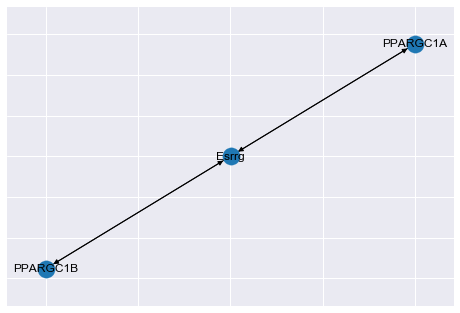

2 minhash has the following distances from 0:
2011


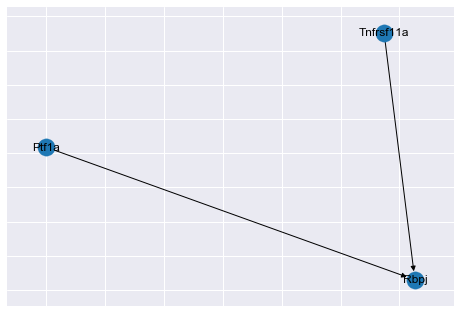

1011


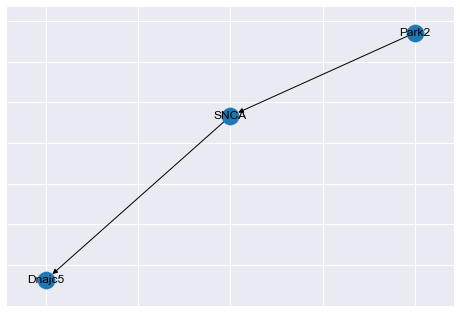

1002


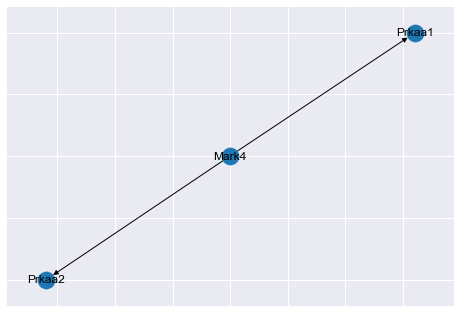

In [114]:
check_table(val_graph, total_hash_data(val_graph, 3))

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  


4 9
6 2
2 32
209 1
3 9
3 minhash has the following distances from 0:
10012


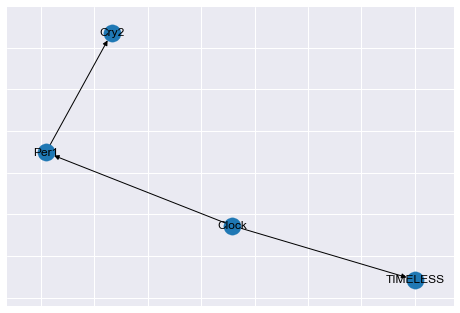

10003


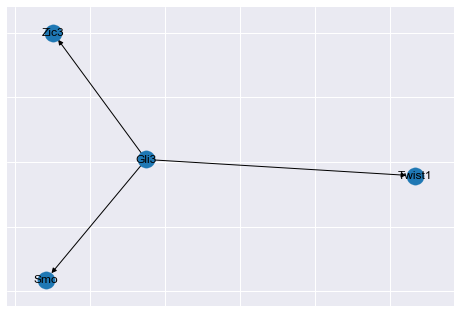

20111


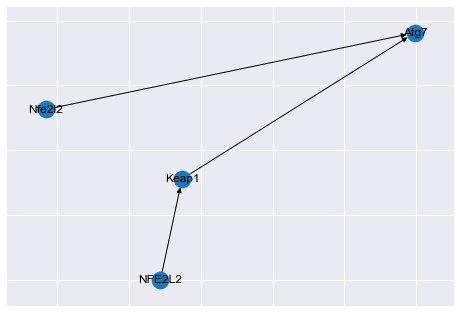

10012


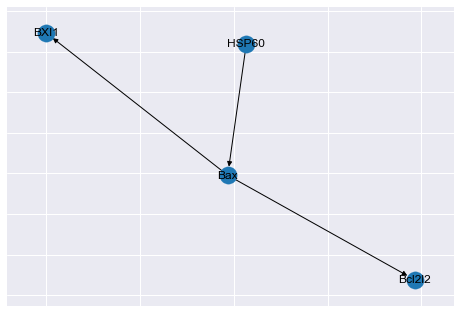

20012


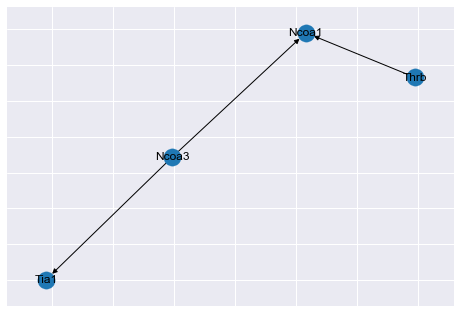

30111


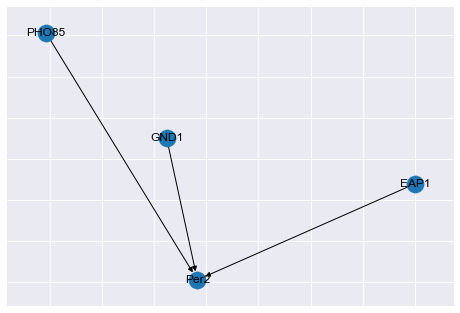

4 minhash has the following distances from 0:
20022


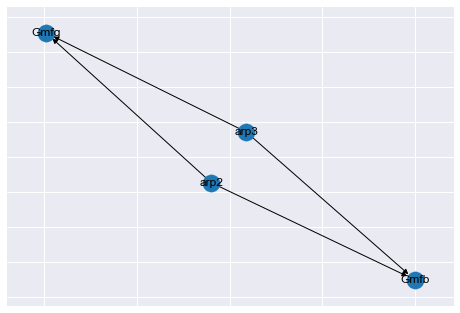

10112


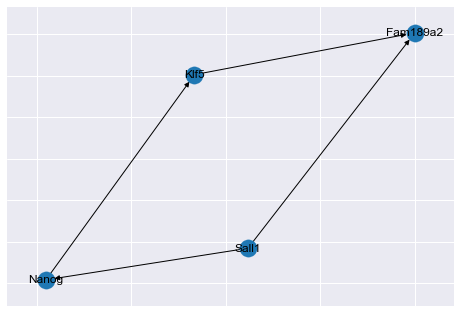

In [115]:
# Read in all bio data
data = pd.read_table("BIOGRID-ORGANISM-Mus_musculus-3.5.182.tab2.txt", low_memory = False)
# Extract desired interactions
val_mus = data.copy()
val_mus.set_index("Experimental System Type", inplace = True)
val_mus = val_mus.filter(items = ["Official Symbol Interactor A", "Official Symbol Interactor B", "Pubmed ID"])
val_mus = val_mus.filter(like = "genetic", axis = 0)
# Create graph of these interactions
val_mus_graph = nx.from_pandas_edgelist(val_mus, "Official Symbol Interactor A", "Official Symbol Interactor B", create_using=nx.DiGraph)
for (key, value) in subgraphs_n(val_mus_graph).items():
    print(key, len(value))
check_table(val_mus_graph, total_hash_data(val_mus_graph, 4))

# Minhash Fingerprinting

Relevant papers: 
https://www.researchgate.net/publication/325439143_Min-Hash_Fingerprints_for_Graph_Kernels_A_Trade-off_among_Accuracy_Efficiency_and_Compression

http://cscubs.cs.uni-bonn.de/2016/proceedings/paper-07.pdf

1. Extract substructures from subgraph ie. paths
2. Map substructures to ints and collect into a set
3. Apply k minhash function to this set to get k hashes
4. The fingerprint is the set of k hashes
5. With this compressed graph representation, group all graphs based on simple hash functions

OR

1. Extract substructures from subgraph ie. paths
2. Map substructures to ints and collect into a set
3. Apply SINGLE minhash function


In [122]:
# second simpler way
def get_paths(subgraphs_n, n):
    graphs_as_paths = []
    for subgraph in subgraphs_n[n]:
        graph_paths = []
        for start in subgraph.nodes:
            for end in subgraph.nodes:
                if (start != end):
                    path_set = nx_get_paths(subgraph, start, end)
                    graph_paths.append(path_set)
        graphs_as_paths.append(graph_paths)
    return graphs_as_paths

def vertex_map(node_num, graph):
    return graph.degree[node_num]
# maps a path to an integer
# possible overflow errors
def fingerprint(path, prime, graph):
    product = 1
    for node in path:
        product = product * prime + vertex_map(node, graph)
    return product

# expects array of path generators
def graph_to_int(path_sets, graph):
    int_set = set()
    for gp in path_sets:
        for path in gp:
            int_set.add(fingerprint(path, 31, graph))
    return int_set

def min_hash(int_set, seed, table_size):
    seeded_mmh3 = partial(mmh3, seed = seed)
#     return min(map(seeded_mmh3, int_set)) % table_size
    return min(map(seeded_mmh3, int_set))

def min_hash_table(subgraphs_n, n, table_size):
    start_time = time.time()
    graph_paths = get_paths(subgraphs_n, n)
#     print("number of subraphs of size", n, "is", len(subgraphs_n[n]))
    table = defaultdict(list)
    for gp, subgraph in zip(graph_paths, subgraphs_n[n]):
        int_set = graph_to_int(gp, subgraph)
        hash_idx = min_hash(int_set, SEED, table_size)
        table[hash_idx].append(subgraph)
    end_time = time.time()
    print(n, end_time - start_time)
    return table
        

In [123]:
# 395
graph_1 = nx.fast_gnp_random_graph(100000, 0.000003, seed=SEED, directed=True)
# 614
graph_2 = nx.fast_gnp_random_graph(600000, 0.00000027, seed=SEED, directed=True)
# 824
graph_3 = nx.fast_gnp_random_graph(500000, 0.0000004, seed=SEED, directed=True)
# 1390
graph_4 = nx.fast_gnp_random_graph(700000, 0.00000030, seed=SEED, directed=True)
# 2229
graph_5 = nx.fast_gnp_random_graph(800000, 0.00000031, seed=SEED, directed=True)
# 3442
graph_6 = nx.fast_gnp_random_graph(900000, 0.00000033, seed=SEED, directed=True)
# 4514
graph_7 = nx.fast_gnp_random_graph(1000000, 0.00000035, seed=SEED, directed=True)
# 14441
# graph_big = nx.fast_gnp_random_graph(3000000, 0.000000129, seed=SEED, directed=True)

graphs = [(graph_1, 1), (graph_2, 2), (graph_3, 3), (graph_4, 4), (graph_5, 5), (graph_6, 6), (graph_7, 7)]
for graph in graphs:
    for n in range(3, 7):
        min_hash_table(sgnu_1, n, 200)

3 0.030102014541625977
4 0.055313825607299805
5 0.09156918525695801
6 0.13760113716125488
3 0.029342174530029297
4 0.056946754455566406
5 0.09430980682373047
6 0.137984037399292
3 0.030508041381835938
4 0.05490708351135254
5 0.09308385848999023
6 0.13759899139404297
3 0.029371023178100586
4 0.056329965591430664
5 0.09024214744567871
6 0.13651084899902344
3 0.031874656677246094
4 0.055187225341796875
5 0.09139513969421387
6 0.1387488842010498
3 0.02951788902282715
4 0.054862260818481445
5 0.08963918685913086
6 0.1416318416595459
3 0.029175758361816406
4 0.054765939712524414
5 0.09096002578735352
6 0.1405501365661621


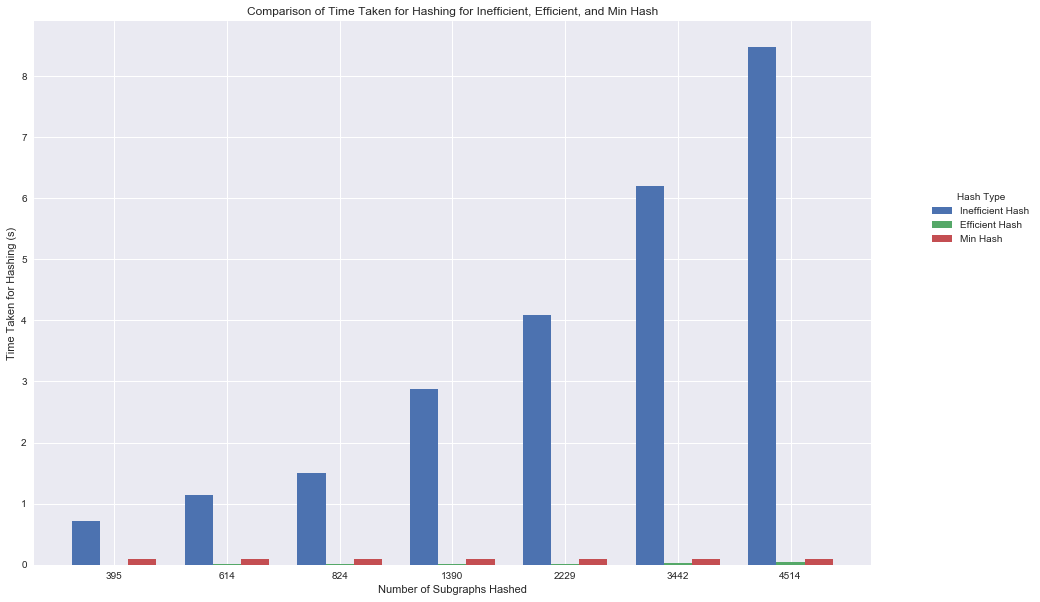

In [137]:
N = 7
# Numbers for motif size 5 (4dp)
old_hash = (0.7211, 1.1358, 1.4961, 2.8814, 4.0942, 6.1916, 8.4732)
new_hash = (0.0034, 0.0058, 0.0072, 0.0124, 0.0196, 0.0300, 0.0491)
minhash_hash = (0.0916, 0.0943, 0.0931, 0.0902, 0.0914, 0.0896, 0.0910)

ind = np.arange(N) 
width = 0.25
plt.figure(figsize=(15,10))
plt.bar(ind, old_hash, width, label='Inefficient Hash')
plt.bar(ind + width, new_hash, width, label='Efficient Hash')
plt.bar(ind + width + width, minhash_hash, width, label='Min Hash')


plt.xlabel('Number of Subgraphs Hashed')
plt.ylabel('Time Taken for Hashing (s)')
plt.title('Comparison of Time Taken for Hashing for Inefficient, Efficient, and Min Hash')

plt.xticks(ind + width, ('395', '614', '824', '1390', '2229', '3442', '4514'))
plt.legend(bbox_to_anchor=(1.2,0.7), loc="upper right", title="Hash Type")
plt.show()

In [118]:
def check_table(graph, table):
#     subgraphs_n = subgraphs_n_uniform(graph)
#     table = min_hash_table(subgraphs_n, n, table_size)
    
    for mh in table.keys():
        # different isomorphisms
        isos = []
        for graph in table[mh]:
            inserted = False
            for iso in isos:
                if nx.is_isomorphic(iso[0], graph):
                    iso.append(graph)
                    inserted = True
                    break
            if not inserted:
                isos.append([graph])
        print(mh, "minhash has the following distances from 0:")
        for iso in isos:
            print(attributes(nx.to_pandas_adjacency(iso[0])))
            plt.figure()
            nx.draw_networkx(iso[0])
            plt.show()

345426475 minhash has the following distances from 0:
10012


/usr/local/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/usr/local/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


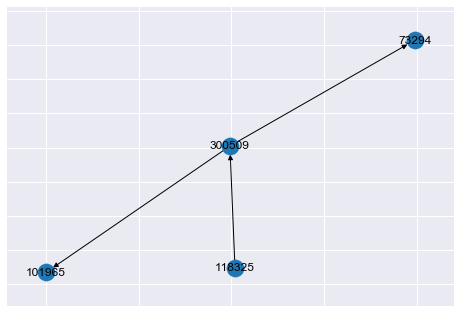

20111


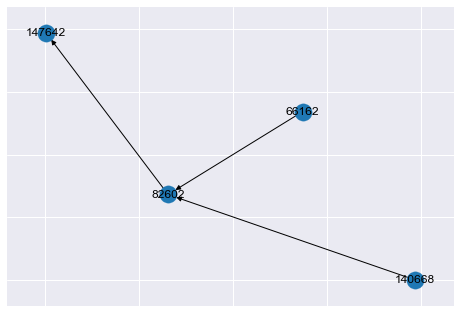

1131125633 minhash has the following distances from 0:
10003


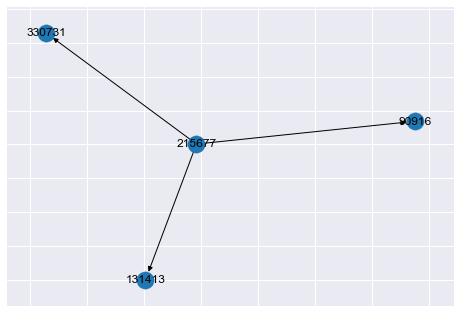

-1833302074 minhash has the following distances from 0:
20111


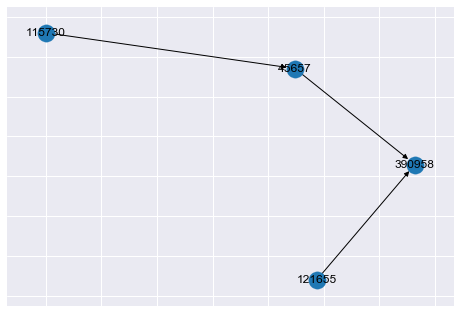

10111


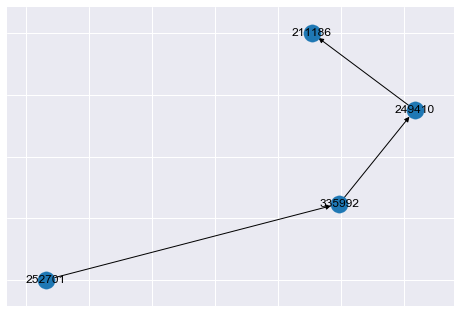

10012


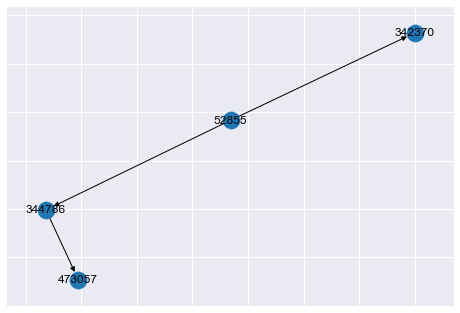

20012


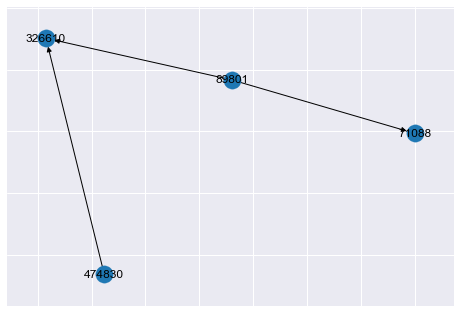

743698810 minhash has the following distances from 0:
30111


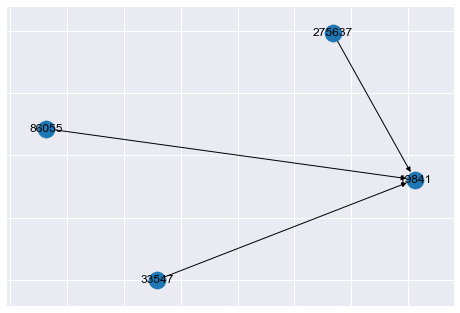

In [97]:
# Is there a rule of thumb for choosing table size?
graph_1 = nx.fast_gnp_random_graph(500000, 0.0000004, seed=SEED, directed=True)
check_table(graph_1, min_hash_table(subgraphs_n_uniform(graph_1), 4, 200))
# For example, minhash can distinguish between the two different 20111s = better quality

-1984373576 minhash has the following distances from 0:
3011111


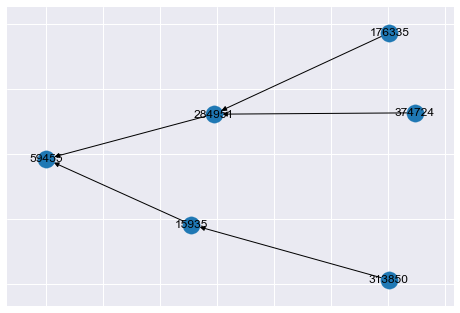

1000122


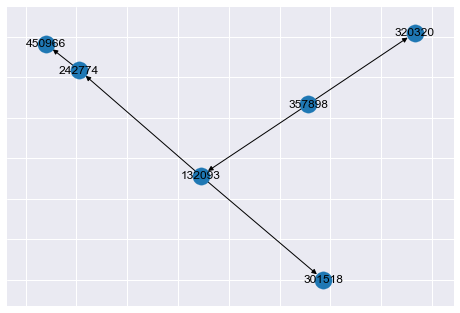

2000122


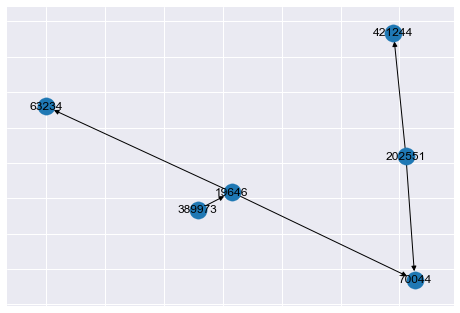

2000023


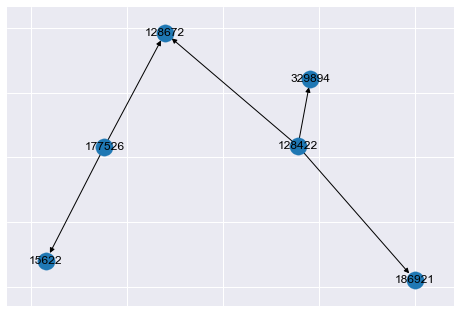

2001112


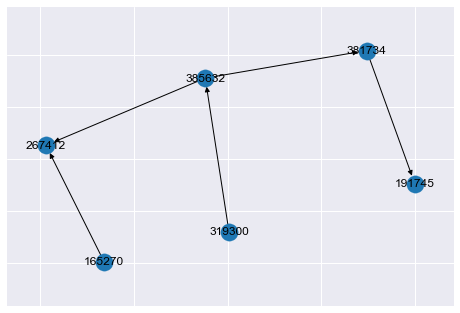

1000113


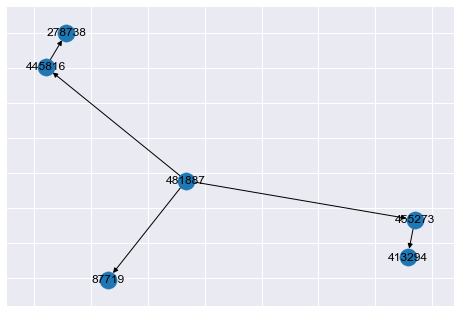

3001112


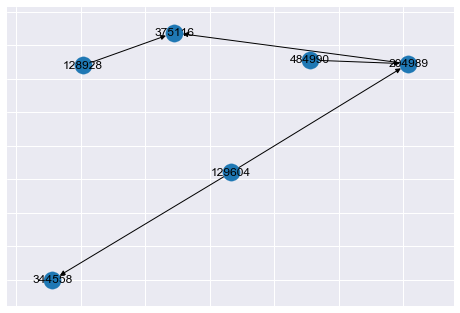

1001112


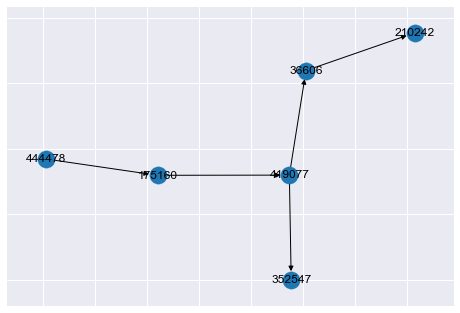

2011111


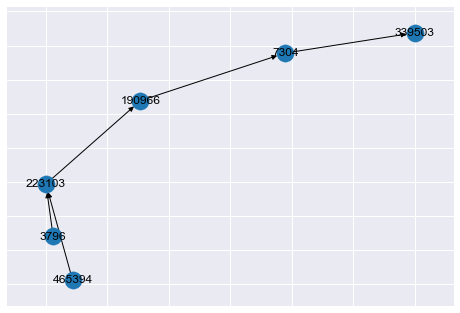

2000113


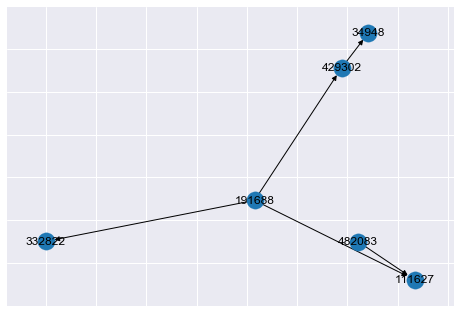

2001112


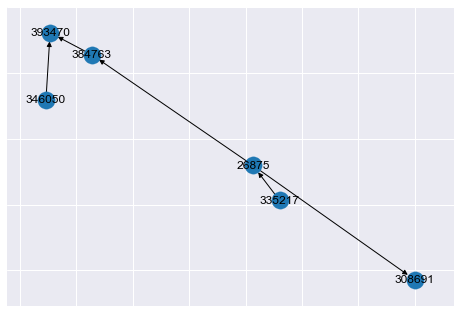

2011111


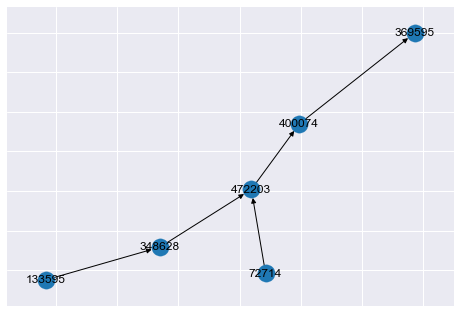

2001112


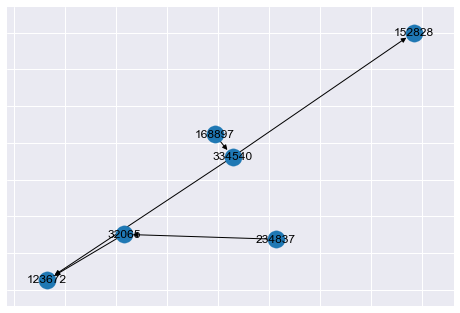

2000113


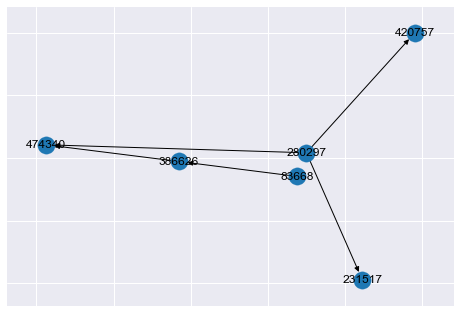

2000113


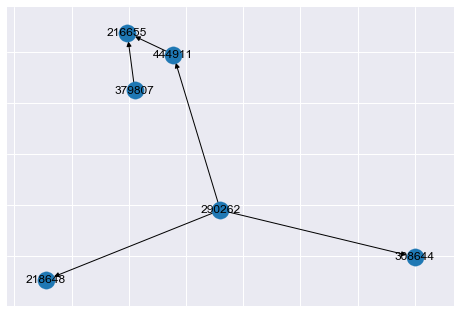

2000122


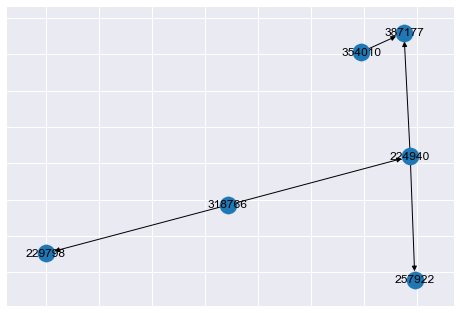

3001112


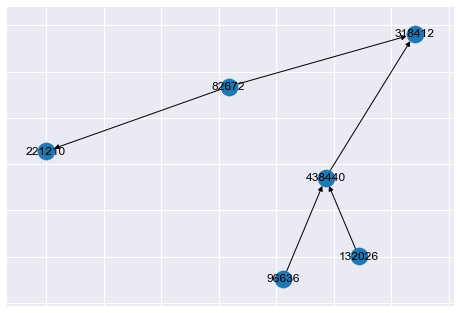

2001112


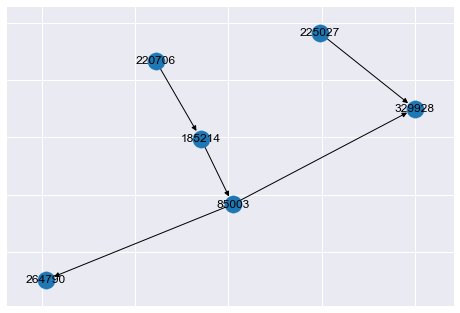

3000113


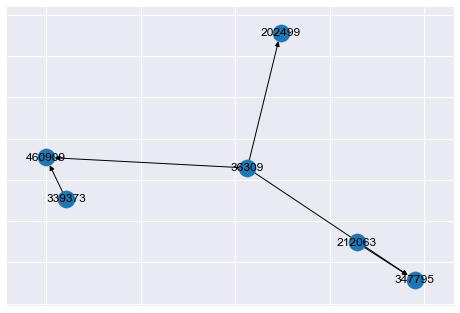

3011111


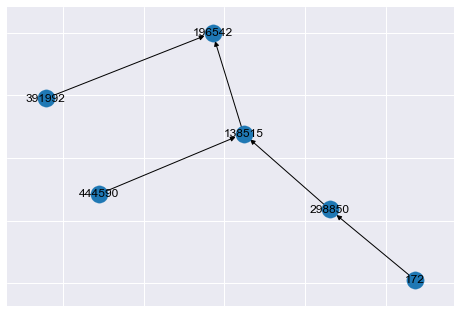

1000113


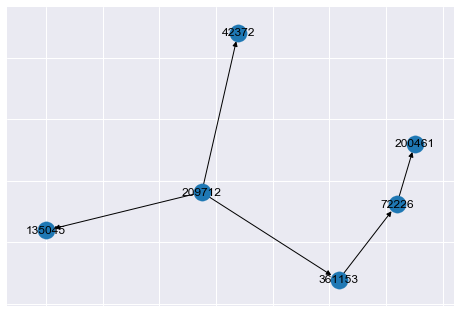

1001112


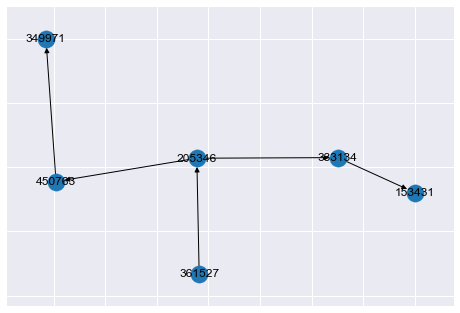

2001112


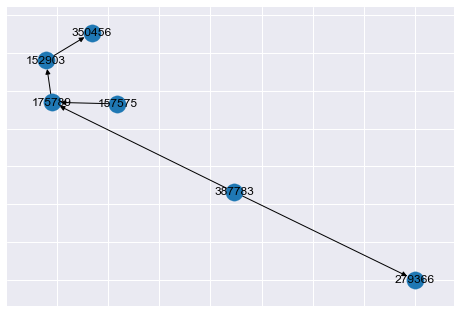

3001112


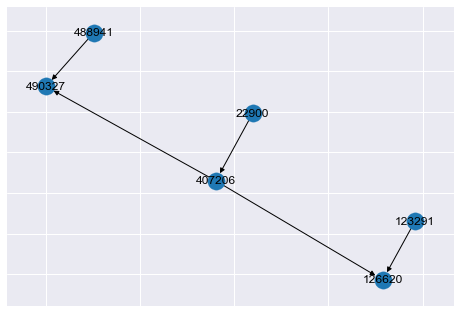

1001112


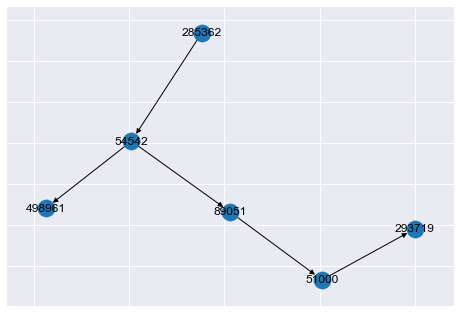

-1790293246 minhash has the following distances from 0:
2000122


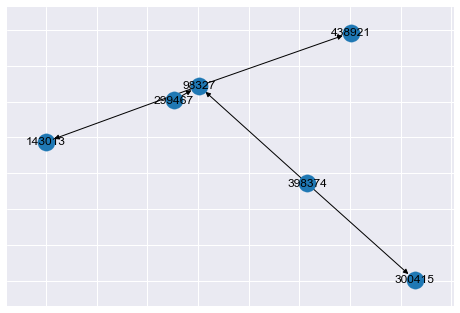

2001112


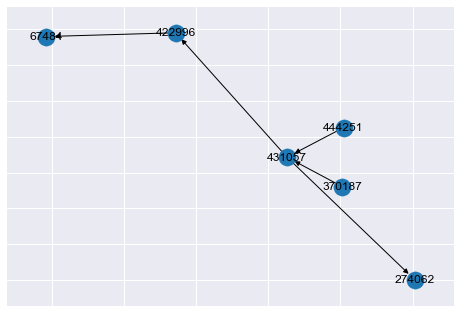

3001112


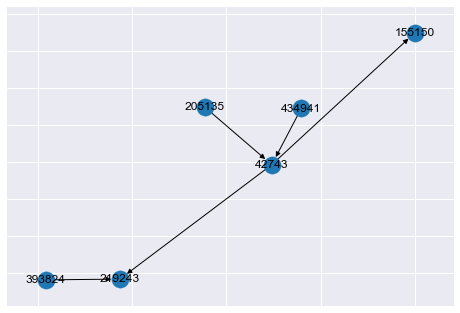

2000113


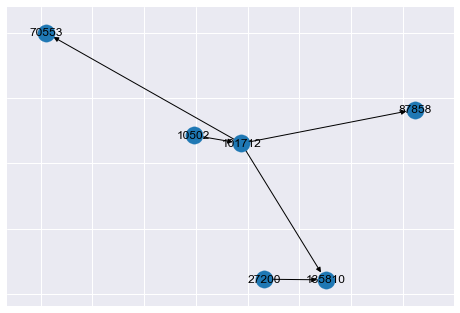

3001112


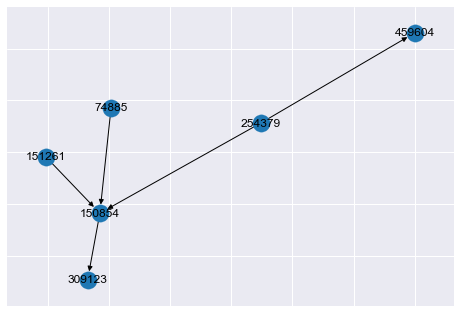

1000113


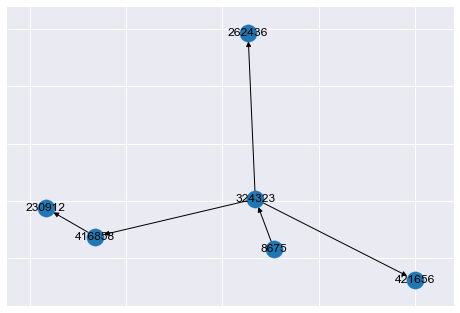

2001112


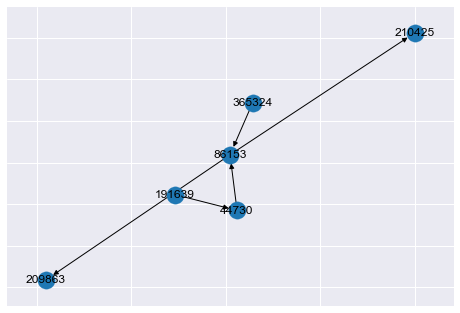

3011111


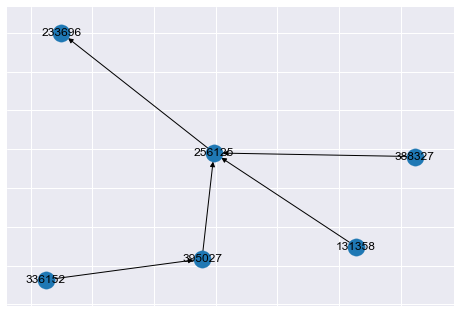

-1833302074 minhash has the following distances from 0:
2011111


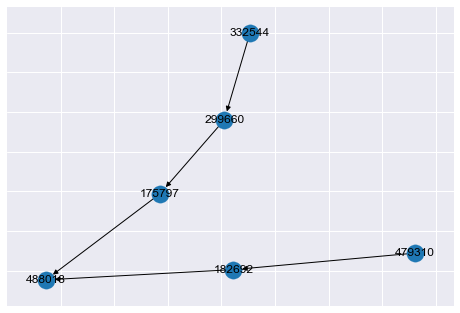

2001112


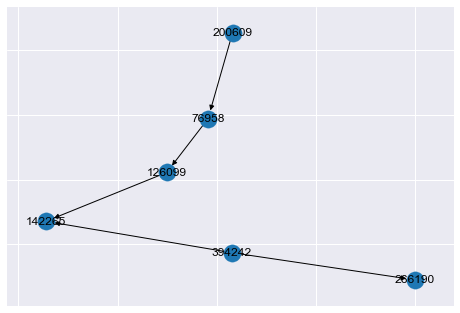

4001112


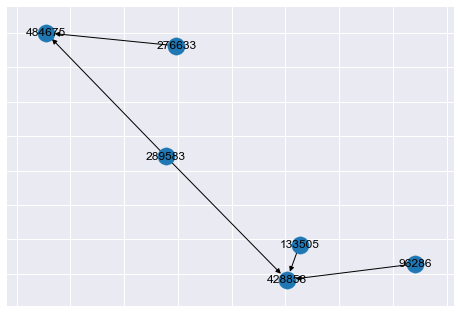

2001112


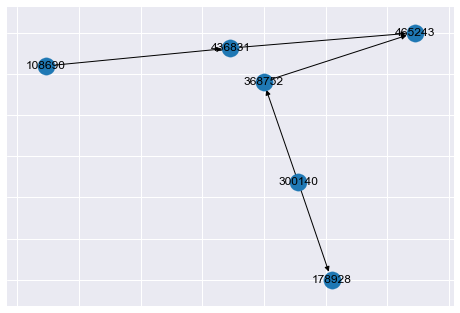

2000122


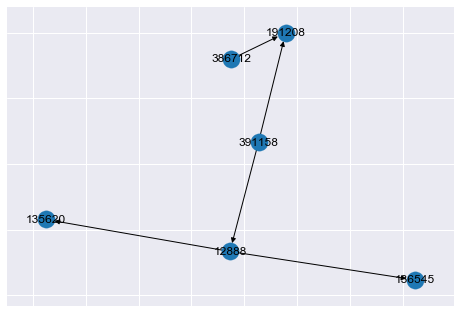

3001112


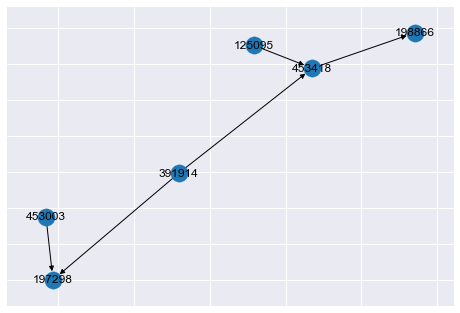

3001112


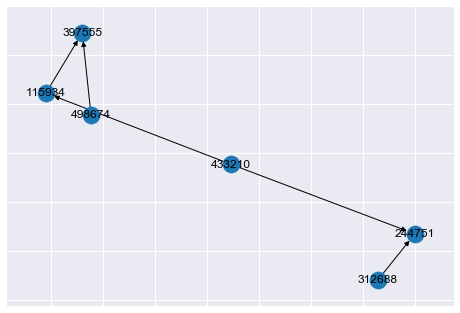

2001112


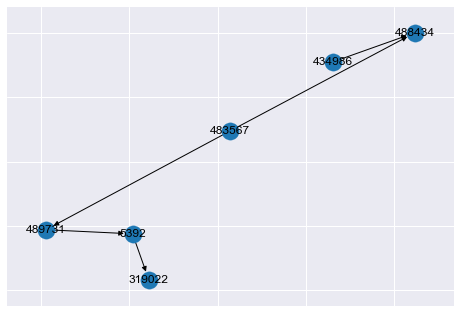

2001112


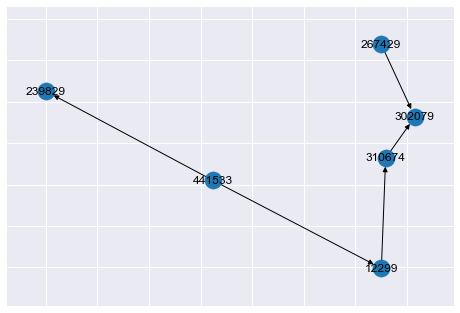

2001112


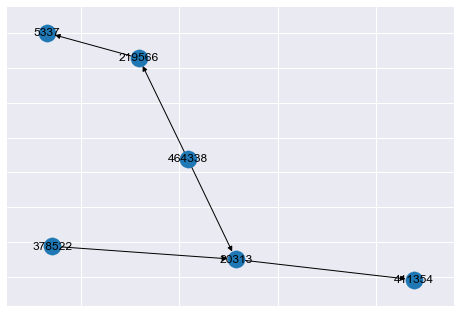

2001112


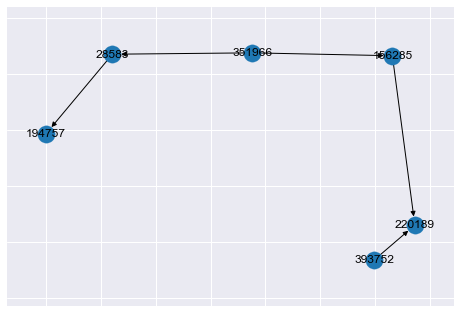

2000122


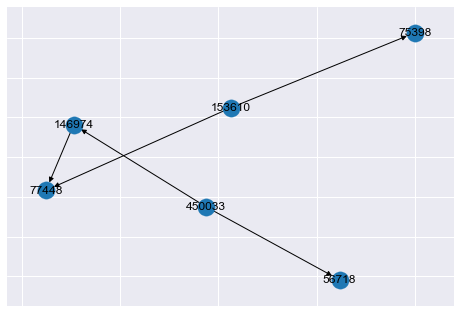

2011111


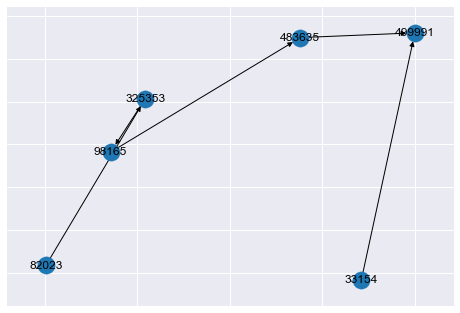

1001112


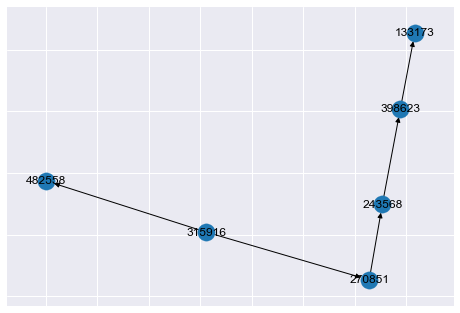

1000122


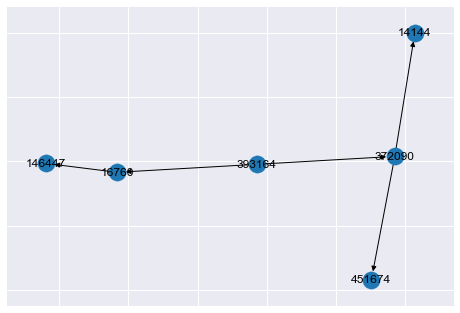

3001112


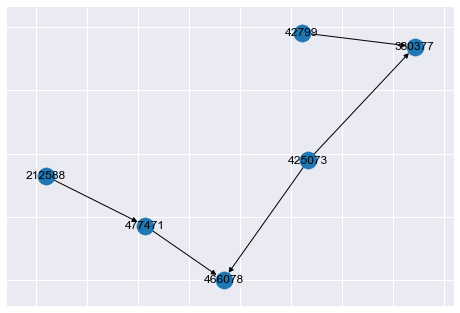

3001112


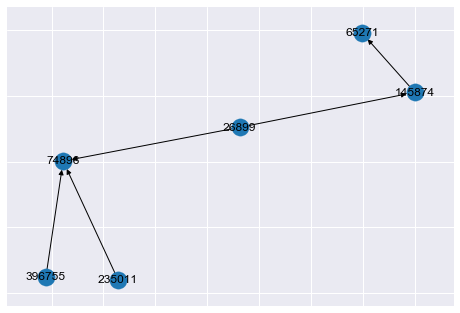

2001112


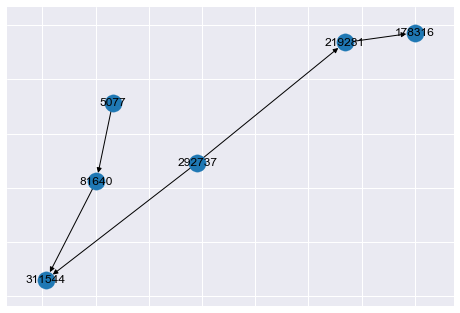

3000122


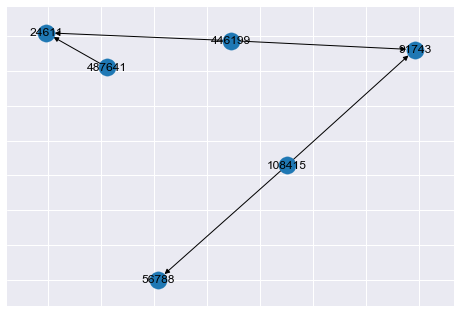

1011111


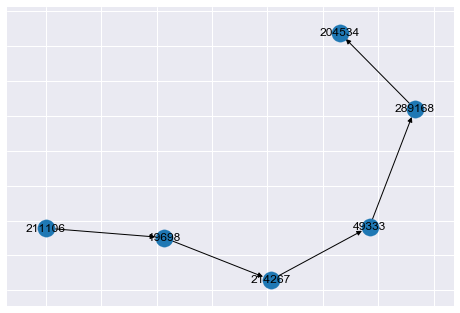

2000122


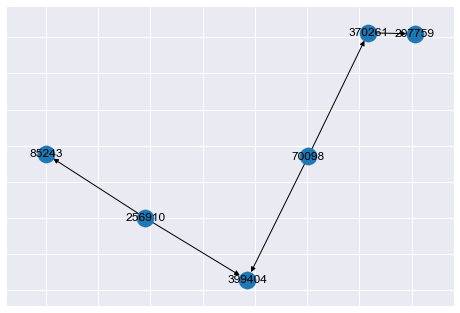

1001112


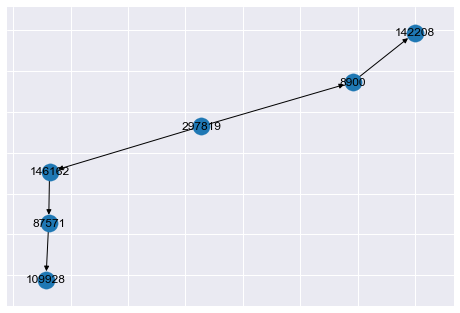

-1225255337 minhash has the following distances from 0:
4011111


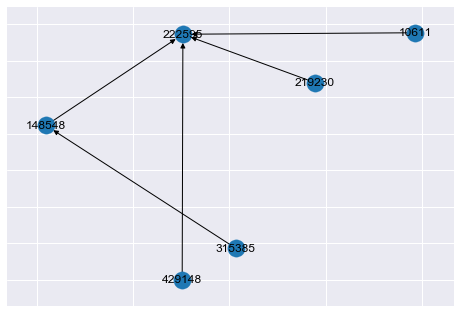

-725236673 minhash has the following distances from 0:
2001112


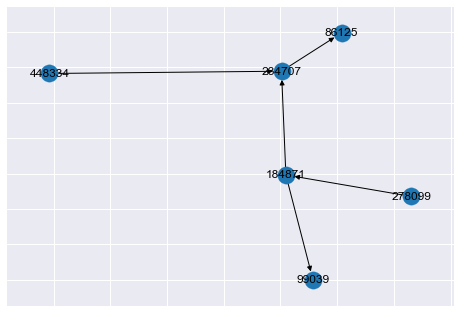

4011111


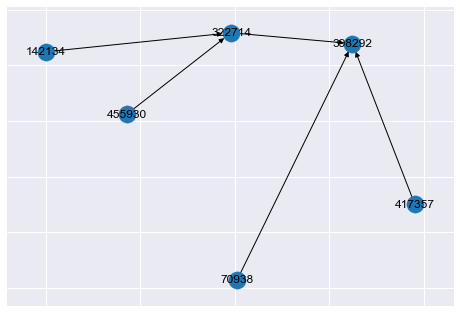

1000122


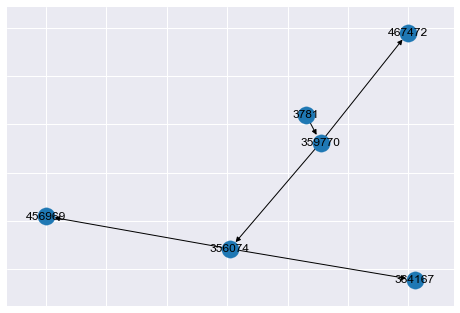

2000113


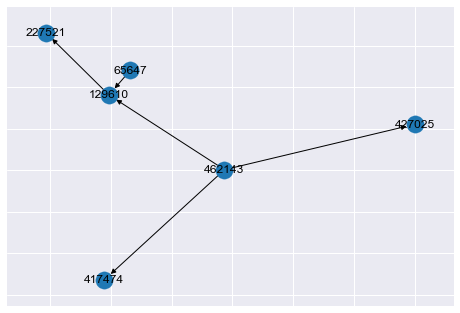

3011111


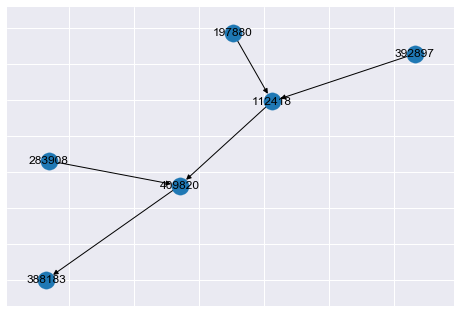

3001112


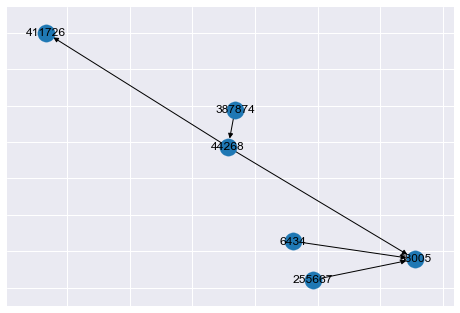

3000113


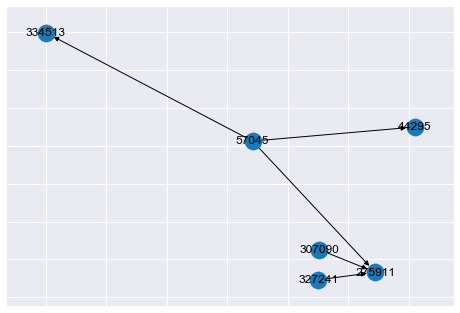

2001112


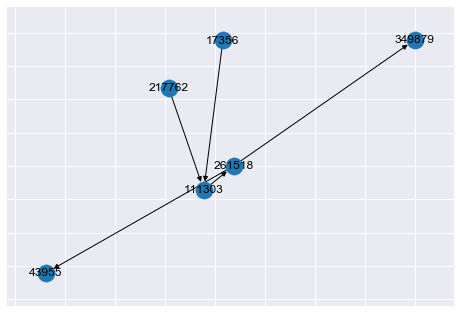

1000023


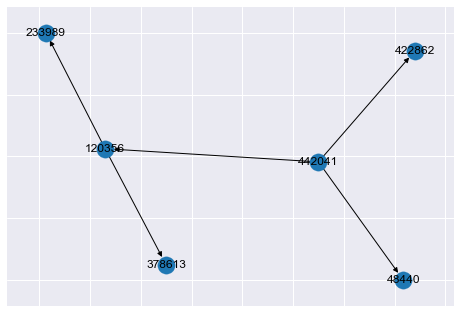

49958882 minhash has the following distances from 0:
3001112


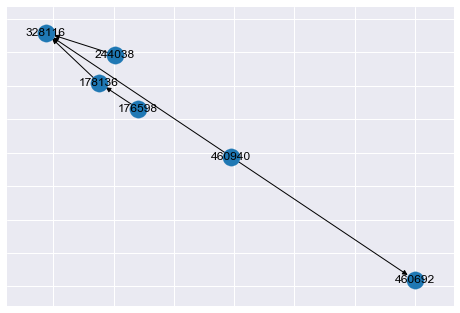

3000122


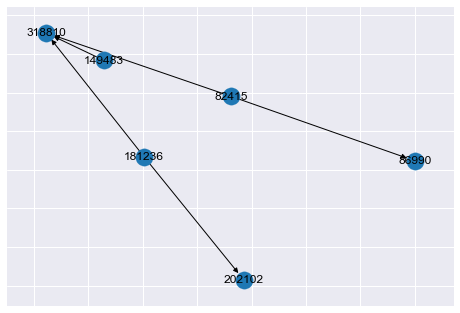

3011111


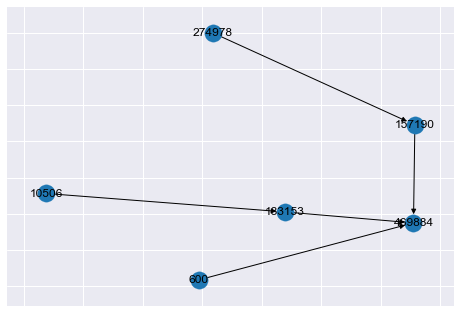

2815511 minhash has the following distances from 0:
2000122


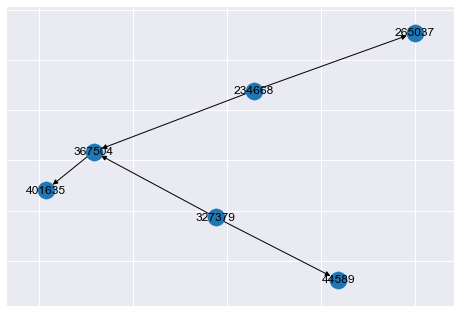

2001112


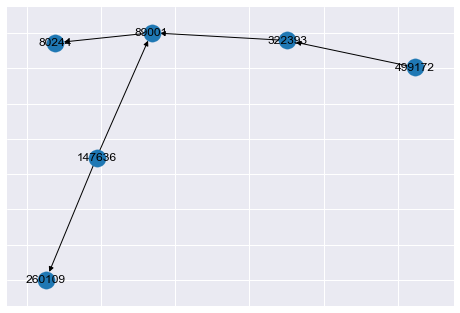

2011111


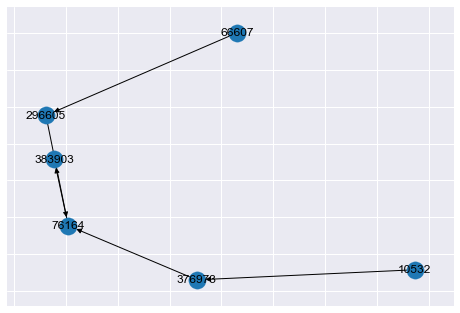

-2026206578 minhash has the following distances from 0:
1000122


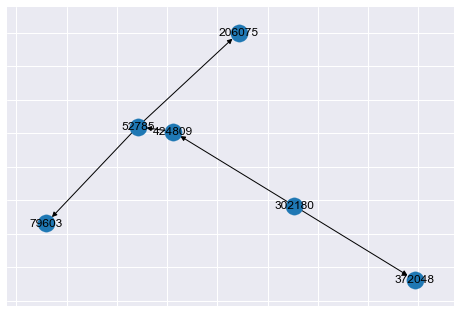

2011111


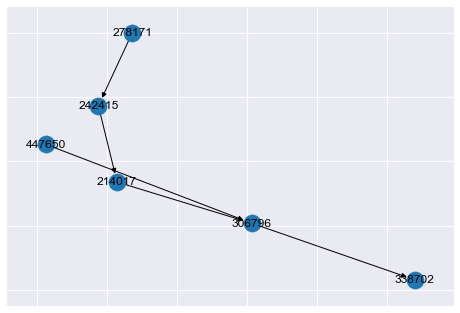

2001112


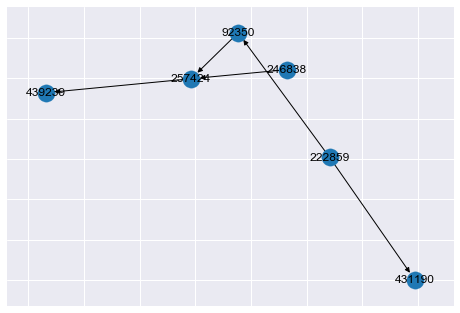

1001112


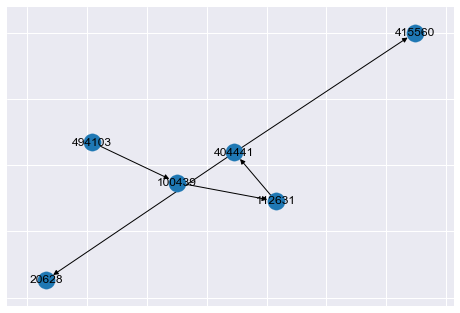

3011111


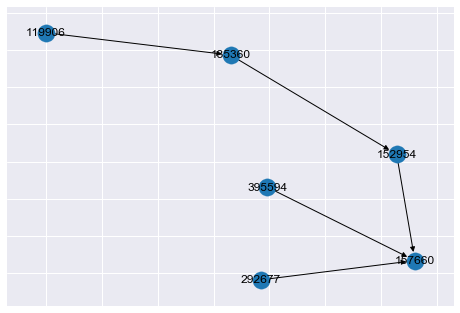

3001112


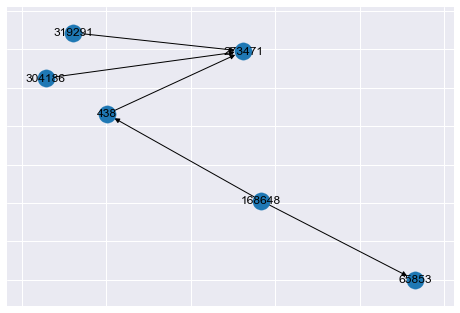

-718381082 minhash has the following distances from 0:
2000014


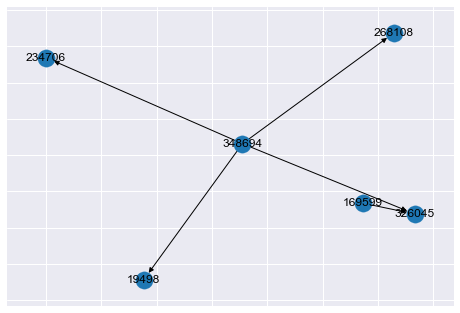

1000014


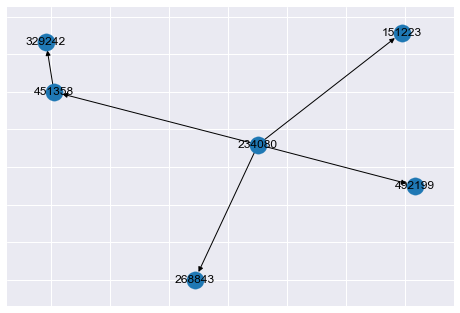

-1737506247 minhash has the following distances from 0:
3011111


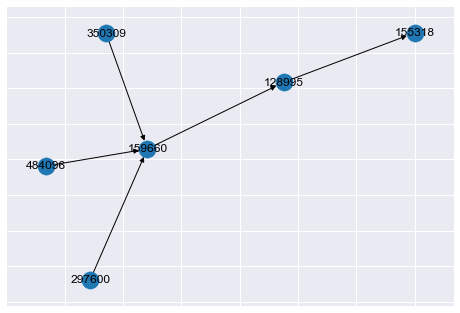

4011111


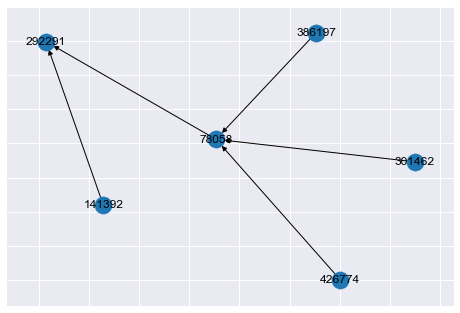

-893916002 minhash has the following distances from 0:
4001112


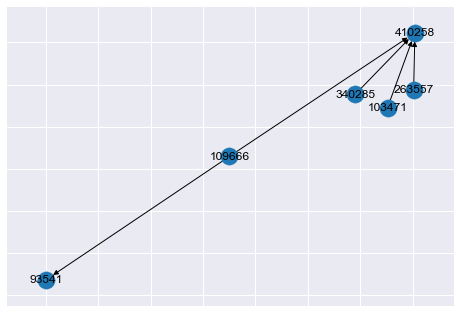

-1238536742 minhash has the following distances from 0:
2000113


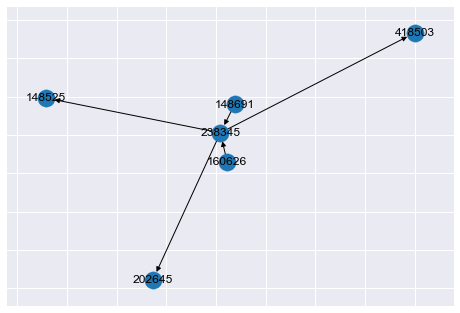

1000014


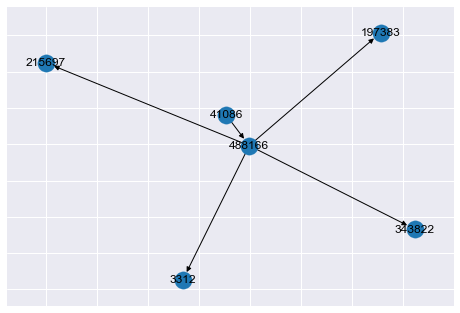

In [98]:
check_table(graph_1, min_hash_table(subgraphs_n_uniform(graph_1), 6, 200))
# For example, minhash cna distinguish between the two different 2011111s = better quality

In [4]:
# Check number of subgraphs
def sg_num(graph):
    print("Graph:")
    sgn = subgraphs_n(graph)
    for key in range(1,7):
        print(key, len(sgn[key]))
    print("")
    print("")

3 0.0009882450103759766
-1984373576 minhash has the following distances from 0:
0012


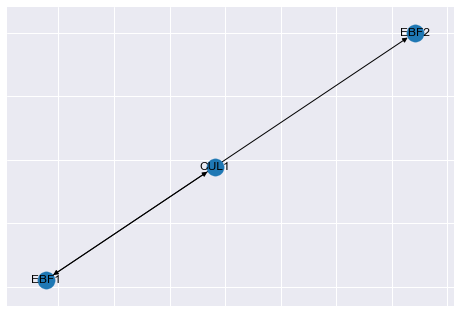

0022


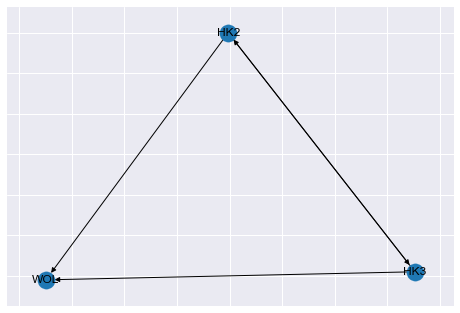

1449563120 minhash has the following distances from 0:
2011


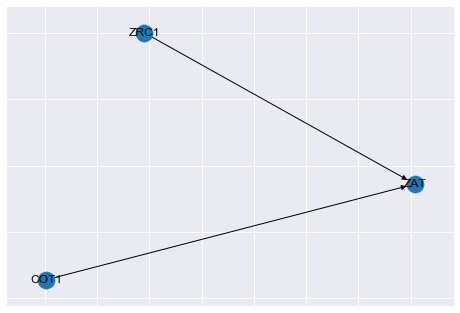

417407963 minhash has the following distances from 0:
1002


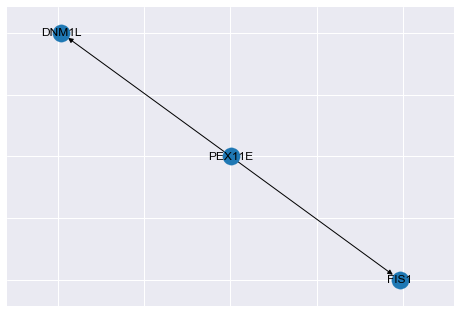

-1939500827 minhash has the following distances from 0:
1011


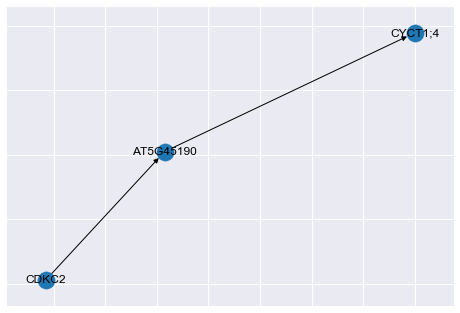

-1833302074 minhash has the following distances from 0:
1012


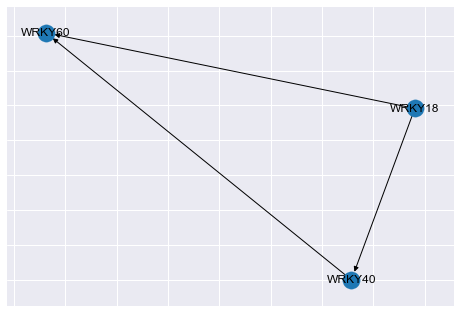

In [138]:
check_table(val_ara_graph, min_hash_table(subgraphs_n(val_ara_graph), 3, 200))

4 0.001188039779663086
-1833302074 minhash has the following distances from 0:
10012


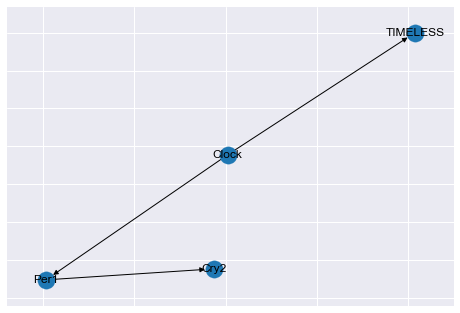

20111


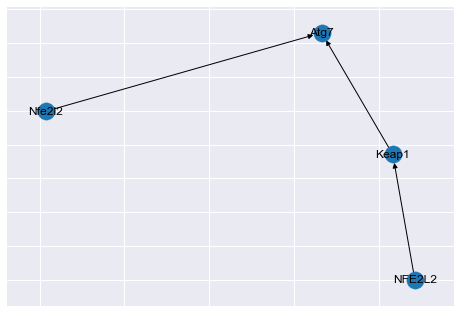

20022


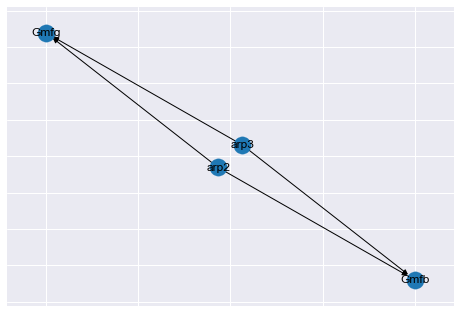

20012


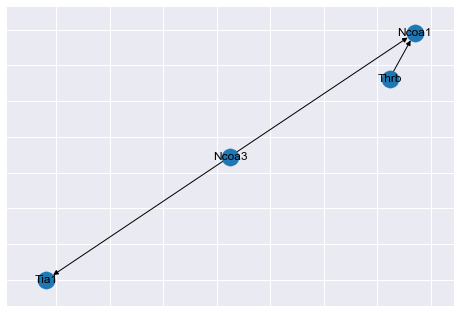

10112


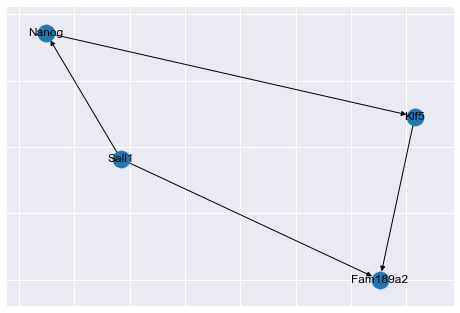

1131125633 minhash has the following distances from 0:
10003


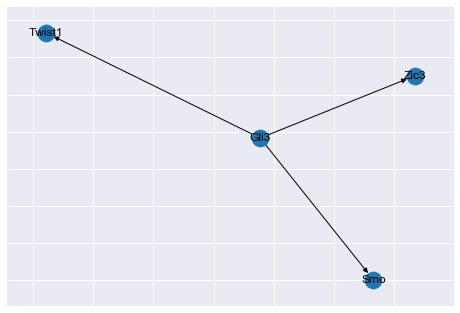

345426475 minhash has the following distances from 0:
10012


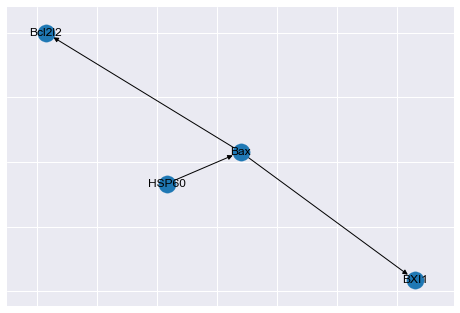

743698810 minhash has the following distances from 0:
30111


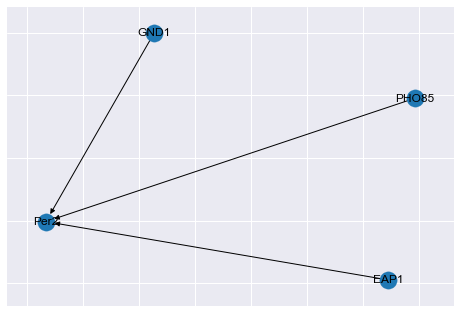

In [139]:
check_table(val_mus_graph, min_hash_table(subgraphs_n(val_mus_graph), 4, 200))